In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_log_error, make_scorer

In [2]:
%matplotlib inline
sns.set()

In [3]:
import pickle
with open('../count-power-transformer.pkl', 'rb') as inf:
    pt = pickle.load(inf)
data = pd.read_pickle('../data-fill-windspeed.pkl.xz')
print(pt, pt.lambdas_)
data.head()

PowerTransformer(copy=True, method='box-cox', standardize=False) [0.31567024]


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,season_4,weather_1,weather_2,weather_3,weather_4,year,month,day,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,9.701265,3,...,0,1,0,0,0,2011,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,7.101665,8,...,0,1,0,0,0,2011,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,7.101665,5,...,0,1,0,0,0,2011,1,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,6.677052,3,...,0,1,0,0,0,2011,1,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,6.677052,0,...,0,1,0,0,0,2011,1,1,4,5


In [4]:
features = [
    'season_1', 'season_2', 'season_3', 'season_4',
    'weather_1', 'weather_2', 'weather_3', 'weather_4',
    'year', 'month', 'weekday', 'hour',
    'holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed',
]
target = 'count_transformed'

In [5]:
x = data[features]
y = data[target]
count_original = data['count']

In [6]:
x_train, x_testing, y_train, _, _, y_testing = train_test_split(
    x, y, count_original,
    test_size=0.25, random_state=42,
)
print(
    'training set:', x_train.shape, y_train.shape,
    '\n',
    'testing set:', x_testing.shape, y_testing.shape,
)

training set: (8164, 18) (8164,) 
 testing set: (2722, 18) (2722,)


## Train linear regression models

In [7]:
models=[LinearRegression(), Ridge(), Lasso(), RidgeCV(cv=5), LassoCV(cv=5)]
model_names=['LinearRegression', 'Ridge', 'Lasso', 'RidgeCV', 'LassoCV']

In [8]:
for model in models:
    model.fit(x_train, y_train)

In [9]:
rmsle = []
predictions = []

for name, model in zip(model_names, models):
    y_pred = model.predict(x_testing)
    y_pred = pt.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    predictions.append(y_pred)
    rmsle.append(
        np.sqrt(
            mean_squared_log_error(
                y_pred,
                y_testing,
            )
        )
    )

result = pd.DataFrame({
    'Model': model_names,
    'RMSLE': rmsle,
})
result

,Model,RMSLE
0,LinearRegression,1.013843
1,Ridge,1.013861
2,Lasso,1.049714
3,RidgeCV,1.013798
4,LassoCV,1.014231


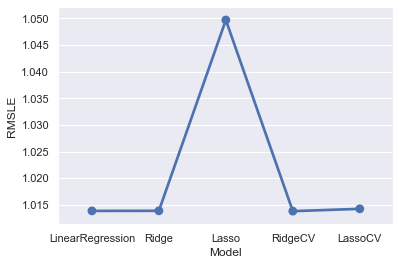

In [10]:
sns.pointplot(
    x='Model', y='RMSLE', data=result,
)

### After adding regulation, weights become small / sparse

In [11]:
weights = pd.DataFrame({
    name: model.coef_ for name, model in zip(model_names, models)
}, index=features)
weights

,LinearRegression,Ridge,Lasso,RidgeCV,LassoCV
season_1,-2.551298e+12,0.514316,-0.000000,0.482279,-0.000000
season_2,-2.551298e+12,0.349121,0.000000,0.340463,0.000000
season_3,-2.551298e+12,-1.144412,-0.000000,-1.125327,-1.081562
season_4,-2.551298e+12,0.280976,0.000000,0.302585,0.000000
weather_1,6.667641e+10,-0.378261,-0.000000,0.069225,-0.000000
weather_2,6.667641e+10,0.036421,0.000000,0.483538,0.317481
weather_3,6.667641e+10,-1.365192,-0.000000,-0.903459,-0.411571
weather_4,6.667641e+10,1.707032,0.000000,0.350696,0.000000
year,2.000010e+00,2.000245,0.000000,1.992510,1.864602
month,2.882485e-01,0.288012,0.164842,0.282392,0.262030


Text(0, 0.5, 'Weights of Linear Regression')

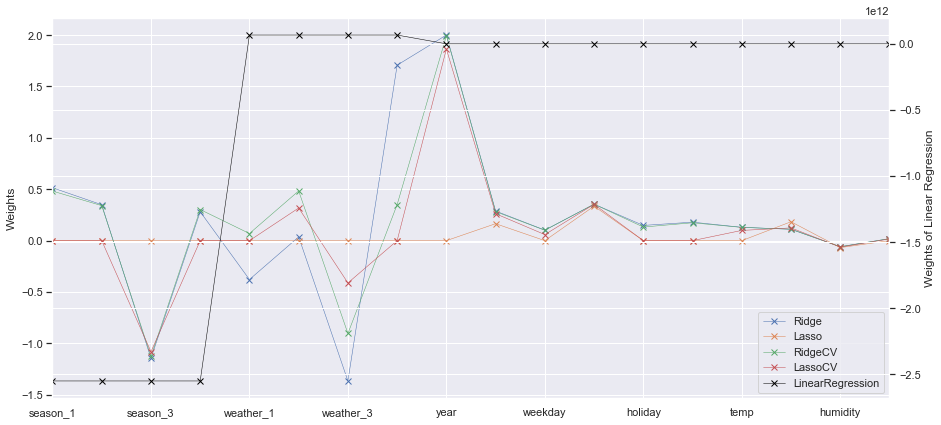

In [12]:
f, ax = plt.subplots(figsize=(15, 7))
weights[['Ridge', 'Lasso', 'RidgeCV', 'LassoCV']].plot(
    marker='x', linewidth=0.5, ax=ax
)
ax2 = ax.twinx()
weights[['LinearRegression']].plot(
    marker='x', linewidth=0.5, ax=ax2, color='black', legend=False
)

ax.legend(
    ax.lines + ax2.lines,
    [l.get_label() for l in ax.lines + ax2.lines],
    loc=4
)
ax.set_ylabel('Weights')
ax2.set_ylabel('Weights of Linear Regression')


### Check the parameters LassoCV and RidgeCV found

In [13]:
from pprint import pprint
pprint({
    name: model.get_params() for name, model in zip(model_names[-2:], models[-2:])
})

{'LassoCV': {'alphas': None,
             'copy_X': True,
             'cv': 5,
             'eps': 0.001,
             'fit_intercept': True,
             'max_iter': 1000,
             'n_alphas': 100,
             'n_jobs': None,
             'normalize': False,
             'positive': False,
             'precompute': 'auto',
             'random_state': None,
             'selection': 'cyclic',
             'tol': 0.0001,
             'verbose': False},
 'RidgeCV': {'alphas': array([ 0.1,  1. , 10. ]),
             'cv': 5,
             'fit_intercept': True,
             'gcv_mode': None,
             'normalize': False,
             'scoring': None,
             'store_cv_values': False}}


## Tunning models by grid search

### Define the scorer

1. define a function calculating RMSLE after inverse transforming data
2. make a scorer from function. `greater_is_better` is False in this case because we want the parameters leading to lowest RMSLE.

In [14]:
def root_mean_squared_log_error(y1, y2, transformer=pt):
    y1 = y1.reshape(-1, 1)
    y2 = y2.reshape(-1, 1)
    if transformer:
        y1 = transformer.inverse_transform(y1)
        y2 = transformer.inverse_transform(y2)
    return np.sqrt(
        mean_squared_log_error(
            y1,
            y2,
        )
    )
rmsle_scorer = make_scorer(root_mean_squared_log_error, greater_is_better=False)

### Searching in grid then

In [15]:
ridge_m = Ridge()
ridge_params = {
    'alpha': [0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]
#     'alpha': np.linspace(50, 199, 10)
}
grid_ridge = GridSearchCV(
    ridge_m,
    ridge_params,
    scoring=rmsle_scorer,
    cv=5
)
grid_ridge.fit(x_train, y_train.to_numpy())

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400,
                                   800, 900, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(root_mean_squared_log_error, greater_is_better=False),
             verbose=0)

### Check the results

In [16]:
grid_ridge.best_estimator_

Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [17]:
grid_ridge.best_score_

-1.0157153723952608

### Visualize how RMSLE varies with different parameters

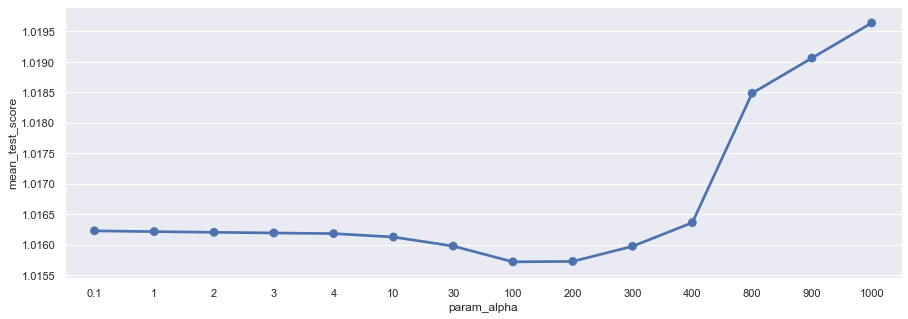

In [18]:
grid_results = pd.DataFrame(grid_ridge.cv_results_).reindex(columns=['param_alpha', 'mean_test_score'])
grid_results['mean_test_score'] = np.abs(grid_results['mean_test_score'])
sns.pointplot(data=grid_results, x="param_alpha", y="mean_test_score")
plt.gcf().set_size_inches(15, 5)

In [19]:
y_pred = grid_ridge.predict(x_testing)
y_pred = pt.inverse_transform(y_pred.reshape(-1, 1)).flatten()
result['Tunned'] = False

result = pd.concat([
    result,
    pd.DataFrame(
        [
            [
                'Ridge',
                np.sqrt(
                    mean_squared_log_error(
                        y_pred,
                        y_testing,
                    )
                ),
                True,
            ]
        ],
        index=[5], columns=['Model', 'RMSLE', 'Tunned'])
], axis=0, sort=False)
result

,Model,RMSLE,Tunned
0,LinearRegression,1.013843,False
1,Ridge,1.013861,False
2,Lasso,1.049714,False
3,RidgeCV,1.013798,False
4,LassoCV,1.014231,False
5,Ridge,1.013355,True


## Also tune the Lasso model

In [20]:
lasso_m = Lasso()
lasso_params = {
    'alpha': [1e-3, 1e-2, 0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,]
#     'alpha': np.linspace(1e-3, 0.1, 10)
}
grid_lasso = GridSearchCV(
    lasso_m,
    lasso_params,
    scoring = rmsle_scorer,
    cv=5
)
grid_lasso.fit(x_train, y_train.to_numpy())

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 2, 3, 4, 10, 30, 100,
                                   200, 300, 400]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(root_mean_squared_log_error, greater_is_better=False),
             verbose=0)

In [21]:
grid_lasso.best_estimator_

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [22]:
grid_lasso.best_score_

-1.0158379850127577

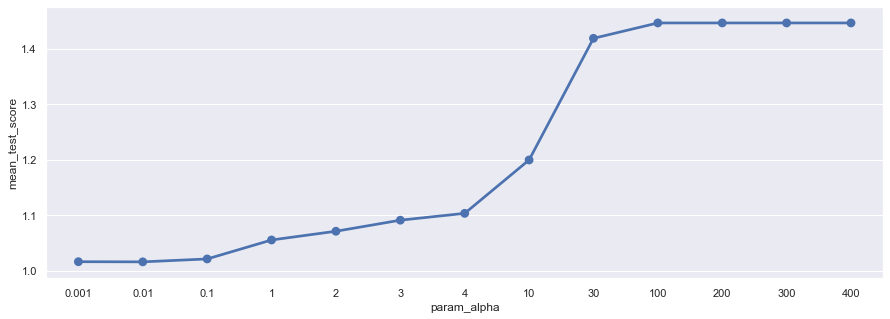

In [23]:
grid_results = pd.DataFrame(grid_lasso.cv_results_).reindex(columns=['param_alpha', 'mean_test_score'])
grid_results['mean_test_score'] = np.abs(grid_results['mean_test_score'])
sns.pointplot(data=grid_results, x="param_alpha", y="mean_test_score")
plt.gcf().set_size_inches(15, 5)

In [24]:
y_pred = grid_lasso.predict(x_testing)
y_pred = pt.inverse_transform(y_pred.reshape(-1, 1)).flatten()
result = pd.concat([
    result,
    pd.DataFrame(
        [
            [
                'Lasso',
                np.sqrt(
                    mean_squared_log_error(
                        y_pred,
                        y_testing,
                    )
                ),
                True,
            ]
        ],
        index=[5], columns=['Model', 'RMSLE', 'Tunned'])
], axis=0, sort=False)
result

,Model,RMSLE,Tunned
0,LinearRegression,1.013843,False
1,Ridge,1.013861,False
2,Lasso,1.049714,False
3,RidgeCV,1.013798,False
4,LassoCV,1.014231,False
5,Ridge,1.013355,True
5,Lasso,1.013582,True


(1.01, 1.02)

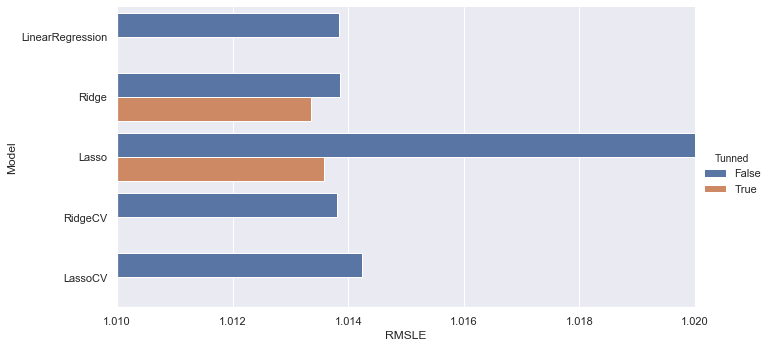

In [25]:
sns.catplot(
    x='RMSLE', y='Model', hue='Tunned',
    data=result,
    kind='bar', height=5, aspect=2
)
plt.gca().set_xlim(1.01, 1.02)